# Estimating Renormalized Mutual Information

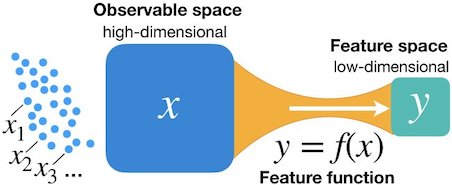

```
Copyright (C) 2020

Code by Leopoldo Sarra and Florian Marquardt
Max Planck Institute for the Science of Light, Erlangen, Germany
http://www.mpl.mpg.de

This work is licensed under the Creative Commons Attribution 4.0 International License. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

If you find this code useful in your work, please cite our article
"Renormalized Mutual Information for Artificial Scientific Discovery", Leopoldo Sarra, Andrea Aiello, Florian Marquardt, arXiv:2005.01912

available on

https://arxiv.org/abs/2005.01912
```


This notebook shows how to implement the estimation of Renormalized Mutual Information in between a sample space $x$ and a low-dimensional feature space $y=f(x)$. 

We remind that in order for the estimation to be accurate with the current technique, the dimension of the feature should be really small (we suggest 1 or 2). This is because we estimate the entropy of the feature with a histogram. Generalizations are possible to larger feature dimension.

Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from renormalizedmutualinformation import *
from utils.features import *

inf = Information()
f = Features()

In [2]:
def plot_outputs_array(x_linspace, outputs_array, fig="par"):
    plt.figure(figsize=[10,5],dpi=300)

    plt.subplot(1,2,1)
    for j in range(outputs_array.shape[1]):
        plt.plot(x_linspace,outputs_array[:, j, 0].astype(np.float),
                 label=outputs_array[0, j,-1],marker='o',markersize=2)
    plt.legend()
    plt.title("Renormalized Mutual Information")
    plt.xlabel(fig)
    plt.ylabel("RMI")
        
        
    plt.subplot(1,2,2)
    for j in range(outputs_array.shape[1]):
        plt.plot(x_linspace,outputs_array[:, j, 1].astype(np.float),
                 label=outputs_array[0, j,-1],marker='o',markersize=2)
    plt.title("Feature Entropy")
    plt.xlabel(fig)
    plt.ylabel("H(y)")
        
    plt.show()

## Quick start

Generate the samples
```python
Samples = ...
```

Feature function. 
feature_func should return the feature with shape [N] and its gradient with shape [N, Nx], where N is the number of samples and Nx the dimension of x
```python
feature, grad = feature_func(Samples)
```

Calculate Mutual Information of the given feature
```python
inf.MutualInformation(feature, grad)
```

A set of commonly used feature functions is in the class f

The function `print_feature_batches` is very useful to calculate mutual information with multiple features at the same time. 
It returns a list of [Mutual Information, Entropy, Grad_term, Label] 
For example
```python
inf.print_feature_batch(Samples,
                        [f.cm, f.sum_x, f.sum_x_j], 
                        ["cm","sum(x[j])" ,"sum(j x[j])"]);
```
Optional argument `is_printing = True` will also print output table.


Information library can also be used to get the probability distribution (returns Px and dx).
It is meaningful to use only with low-dimensional variables
```python
Px = inf.produce_P(Samples)
```
Calculate the Entropy of a probability distribution 
```python
Hx = inf.Entropy(*Px)
```

The feature function `joinTwo` builds a 2d feature given two 1d features. It is used in this way:
```python
f.joinTwo(Samples, feature_and_grad1, feature_and_grad2)
```
where `feature_and_grad1` and `feature_and_grad2` are functions.

## Simplest example

Generate samples 

```
N=1000 # number of samples
Nx=10 # dimension of x
x = get_samples(...)
```

Example: feature function 

$$f(x)=\sum(x_j^2)$$

calculate both the feature and its gradient!

```python
# x has shape [N,Nx]
def f_and_fgrad(x): 
    return(sum(x**2,axis=1), 2*x) 
```

returns shape [N] for the feature and shape [N,Nx] for the feature  gradient (the second return value)
```
samples=random.randn(N,Nx)
feature,feature_grad=f_and_fgrad(samples)
```

```
print("MI=", inf.MutualInformation(feature, feature_grad))
```

---

## Two-dimensional Gaussian

In [3]:
from utils.examples import RandomGaussian

In [4]:
rg = RandomGaussian(2)
rg.cov0 = [[1,0],[0,0.7]]

Samples = rg.sample(10000000)

Example: one dimensional feature

In [5]:
feature, feature_grad = f.linear(Samples, np.pi/3)

In [6]:
inf.MutualInformation(feature, feature_grad)

1.2917191330050515

Example: two dimensional feature

This example shows how to use the `joinTwo` feature (to create a 2d feature) starting from two given feature functions

In [7]:
feature, feature_grad = f.joinTwo(Samples, 
                                 lambda x: f.linear(x,np.pi/3),
                                 lambda x: f.linear(x,0))

In [8]:
inf.MutualInformation(feature, feature_grad)

2.6591257061544944

Please note that in the Gaussian case the optimal feature is always exactly the same given by PCA (since the optimal feature is actually linear)

# Wave Packet

In [9]:
from utils.examples import WavePacket
wp = WavePacket()

## Show a single sample

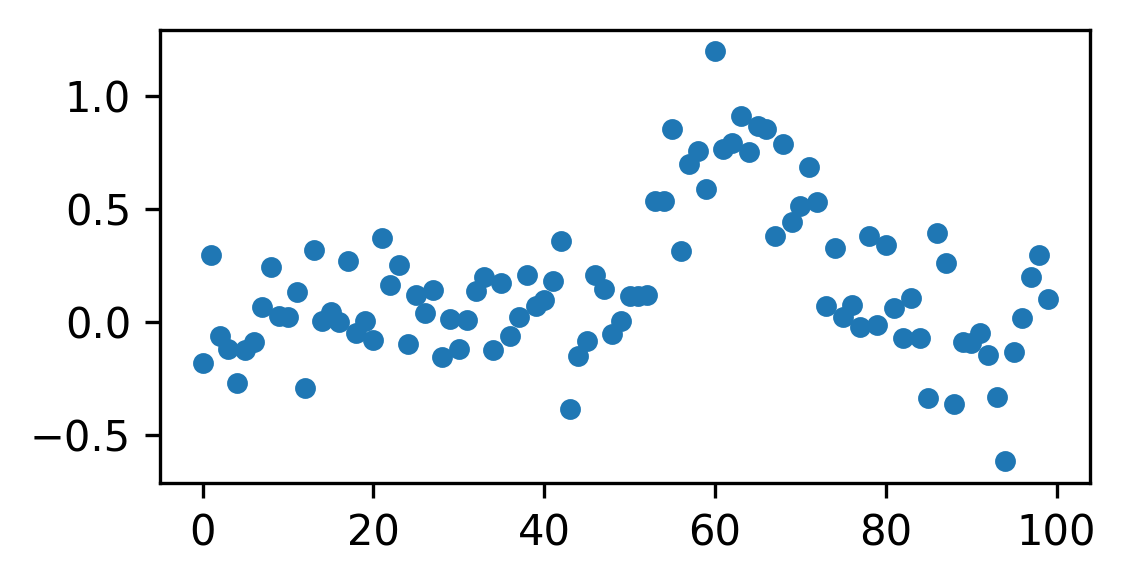

In [10]:
N_pixels=100
Samples = wp.produce_Wave_Packet(n_pixels=N_pixels,n_samples=200,width=9.0,noise=0.2,pos_range=[30,70])

js=np.array(range(N_pixels))
plt.figure(figsize=(4,2),dpi=300)
plt.scatter(js,Samples[0,:],s=16)
plt.show()

## Show picture with one sample per row

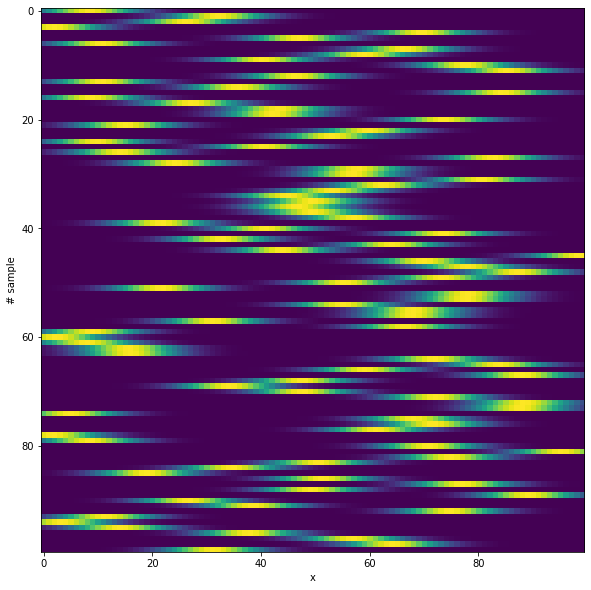

Feature              MI       H     MI-H
cm                   -3.10  -5.40  +2.30
sum(x[j])            -3.10  -0.79  -2.30
sum(j x[j])          +0.76  +7.11  -6.35
sum(j x[j]**2)       +1.27  +6.83  -5.56
<x|j|x>              +3.54  +4.50  -0.96
PCA                  +1.12  +1.12  +0.00
<x|j|x>; cm          -1.23  -2.58  +1.34


In [11]:
Samples = wp.produce_Wave_Packet(n_pixels=100,n_samples=10000,width=9.0)

feature_and_grad = f.sum_x2_j(Samples)
P = inf.produce_P(feature_and_grad[0])
H = inf.Entropy(*P)

inf.MutualInformation(*feature_and_grad)

wp.plot(Samples)
inf.print_feature_batch(Samples,
                        [f.cm, f.sum_x, f.sum_x_j, f.sum_x2_j, f.qm_j, f.pca,
                        lambda x: f.joinTwo(x, f.qm_j, f.cm)], 
                        ["cm","sum(x[j])" ,"sum(j x[j])", "sum(j x[j]**2)", "<x|j|x>",  "PCA",
                        "<x|j|x>; cm"]);

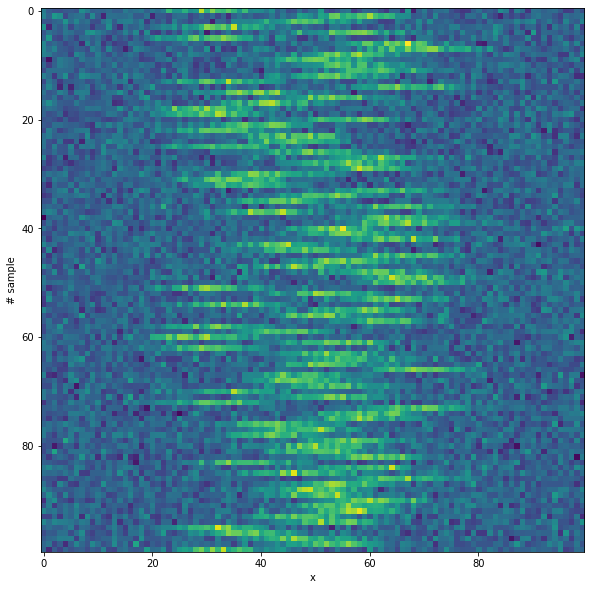

In [12]:
N_pixels=100
Samples = wp.produce_Wave_Packet(n_pixels=N_pixels,n_samples=200,width=9.0,noise=0.2,pos_range=[30,70])

wp.plot(Samples)

## Without amplitude noise (fixed amplitude)

In [13]:
n_noise=10
noises=np.linspace(0.0,0.4,n_noise)

outputs = []
for noise in noises:
    Samples = wp.produce_Wave_Packet(n_pixels=100,n_samples=300000,width=9.0,noise=noise,pos_range=[30,70])
    minf = inf.print_feature_batch(Samples,
                        [f.pca, f.sum_x, f.sum_x_j, f.sum_x2_j, f.qm_j], 
                        [ "PCA", r"$\sum x_i$" ,r"$\sum i x_i$", r"$\sum i x_i^2$", "<x|j|x>"],
                        is_printing=False);
    outputs.append(np.array(minf))

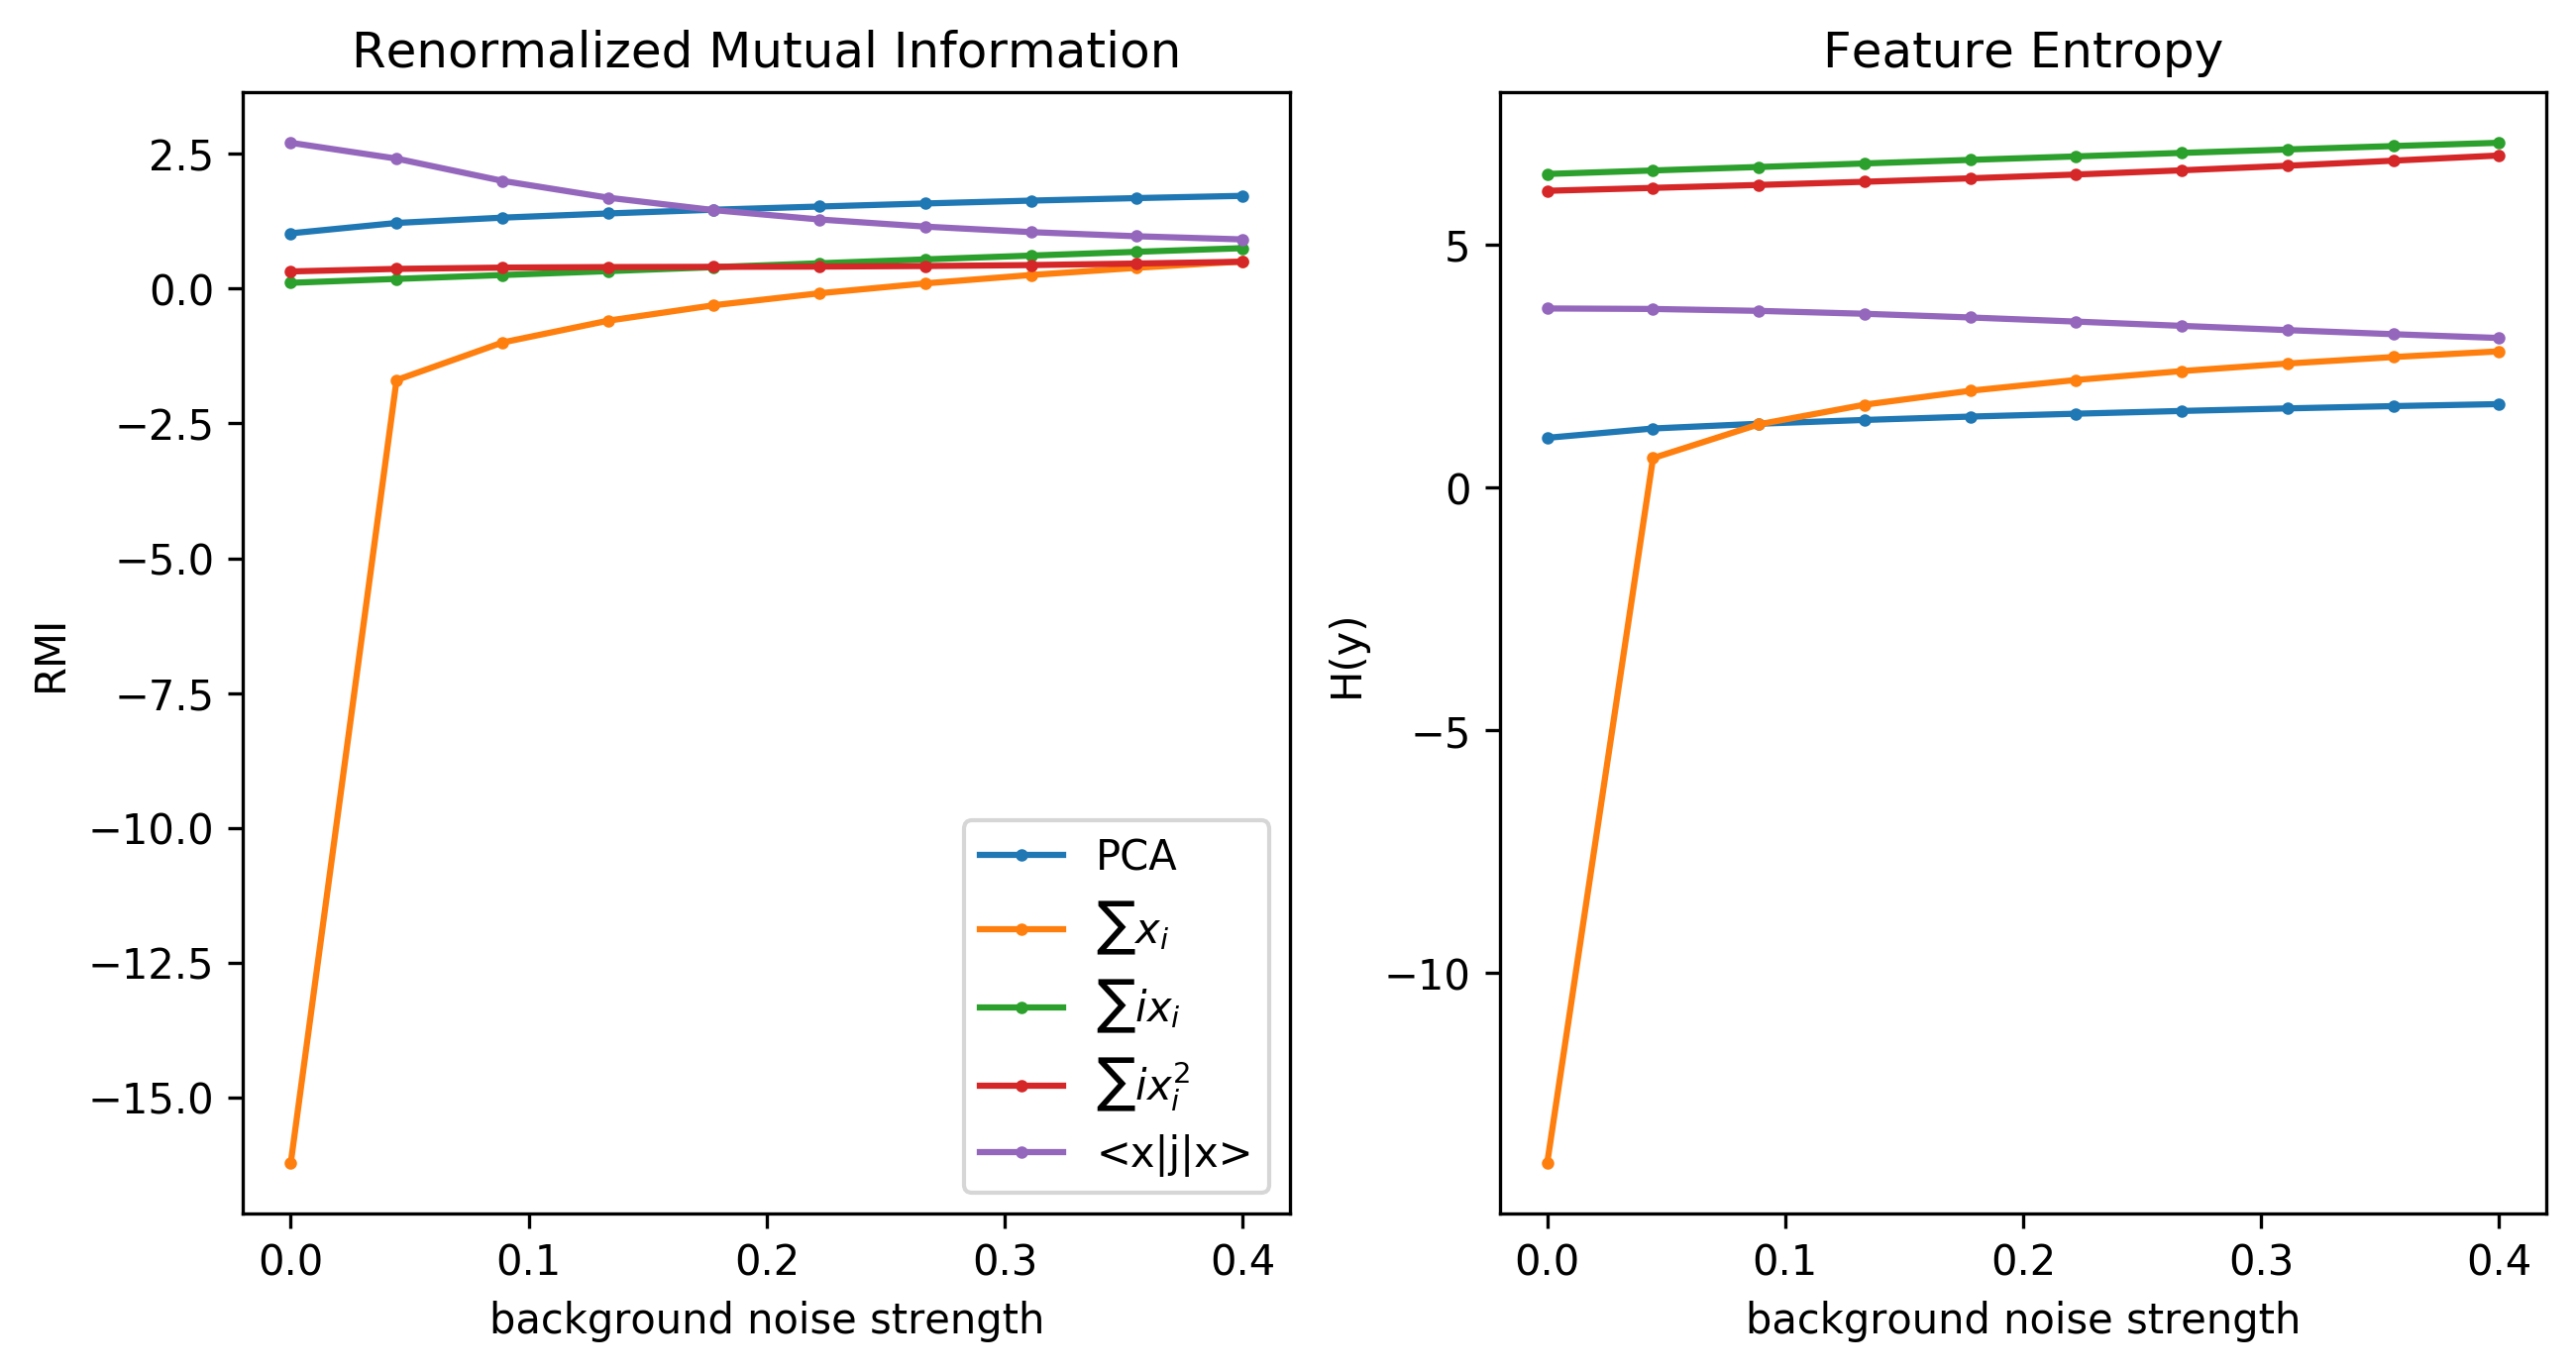

In [14]:
outputs_array = np.array(outputs)
plot_outputs_array(noises,outputs_array,fig="background noise strength")

## With amplitude noise (fixed background noise)

In [15]:
n_noise=20
noises=np.linspace(0.0,1,n_noise)

outputs = []
for noise in noises:
    Samples = wp.produce_Wave_Packet(n_pixels=100,n_samples=300000,width=9.0,noise=0.1,pos_range=[30,70],
                                    noisy_amplitude=noise)
    minf = inf.print_feature_batch(Samples,
                        [f.sum_x, f.sum_x_j, f.sum_x2_j, f.qm_j, f.pca], 
                        [r"$\sum x_i$" ,r"$\sum i x_i$", r"$\sum i x_i^2$", "<x|j|x>",  "PCA"],
                        is_printing=False);
    outputs.append(np.array(minf))

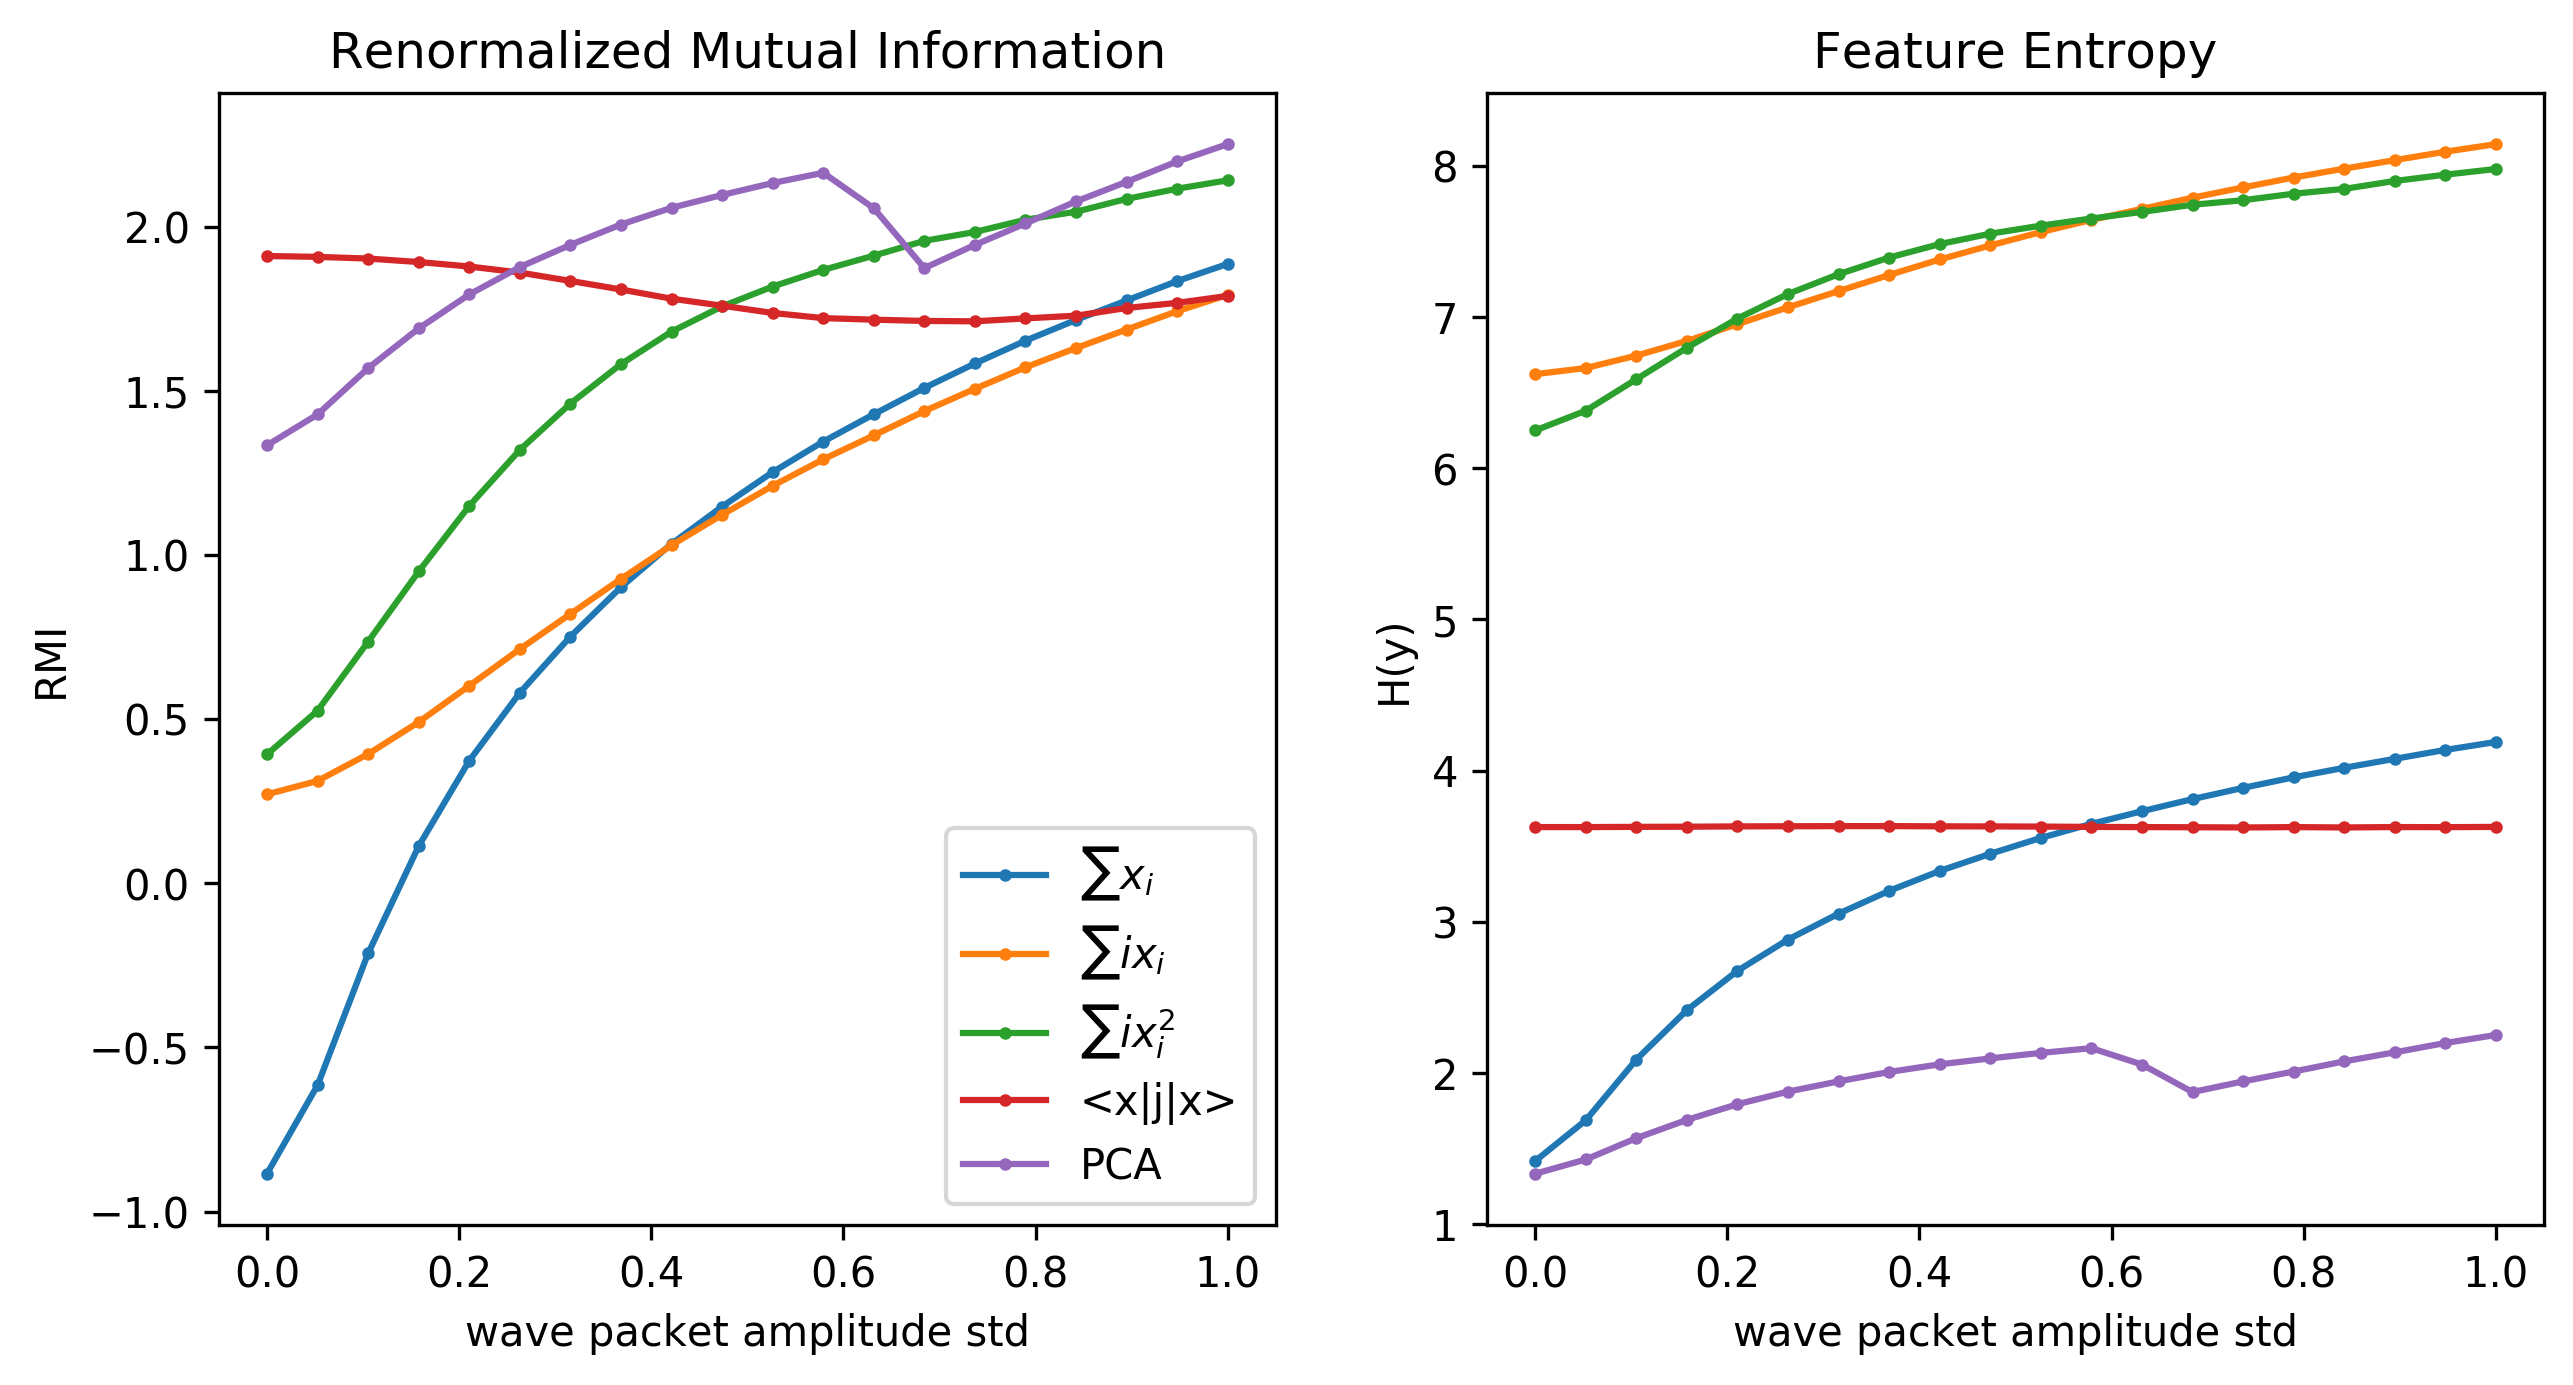

In [16]:
outputs_array = np.array(outputs)
plot_outputs_array(noises,outputs_array,fig="wave packet amplitude std")

## Numerical Check: Reparametrization Invariance

In [17]:
def f_rep(samples,f_funct):
    feat = f_funct(samples)
    
    f_new =feat[0]**3 + 5*feat[0]
    grad_new = 3*(feat[0]**2)[:,np.newaxis]*feat[1] + 5*feat[1]
    return f_new, grad_new

In [18]:
Samples = wp.produce_Wave_Packet(n_pixels=100,n_samples=300000,width=9.0,noise=0.2,pos_range=[30,70])

$0.1 y^3 +5 y$

In [19]:
n_noise=10
noises=np.linspace(0.0,0.4,n_noise)

outputs = []
for noise in noises:
    Samples = wp.produce_Wave_Packet(n_pixels=100,n_samples=300000,width=9.0,noise=noise,pos_range=[30,70])
    minf = inf.print_feature_batch(Samples,
                        [f.sum_x2_j, lambda s :f_rep(s, f.sum_x2_j)], 
                        [  r"$\sum i x_i^2$", r"$y+y^3$"],
                        is_printing=False);
    outputs.append(np.array(minf))

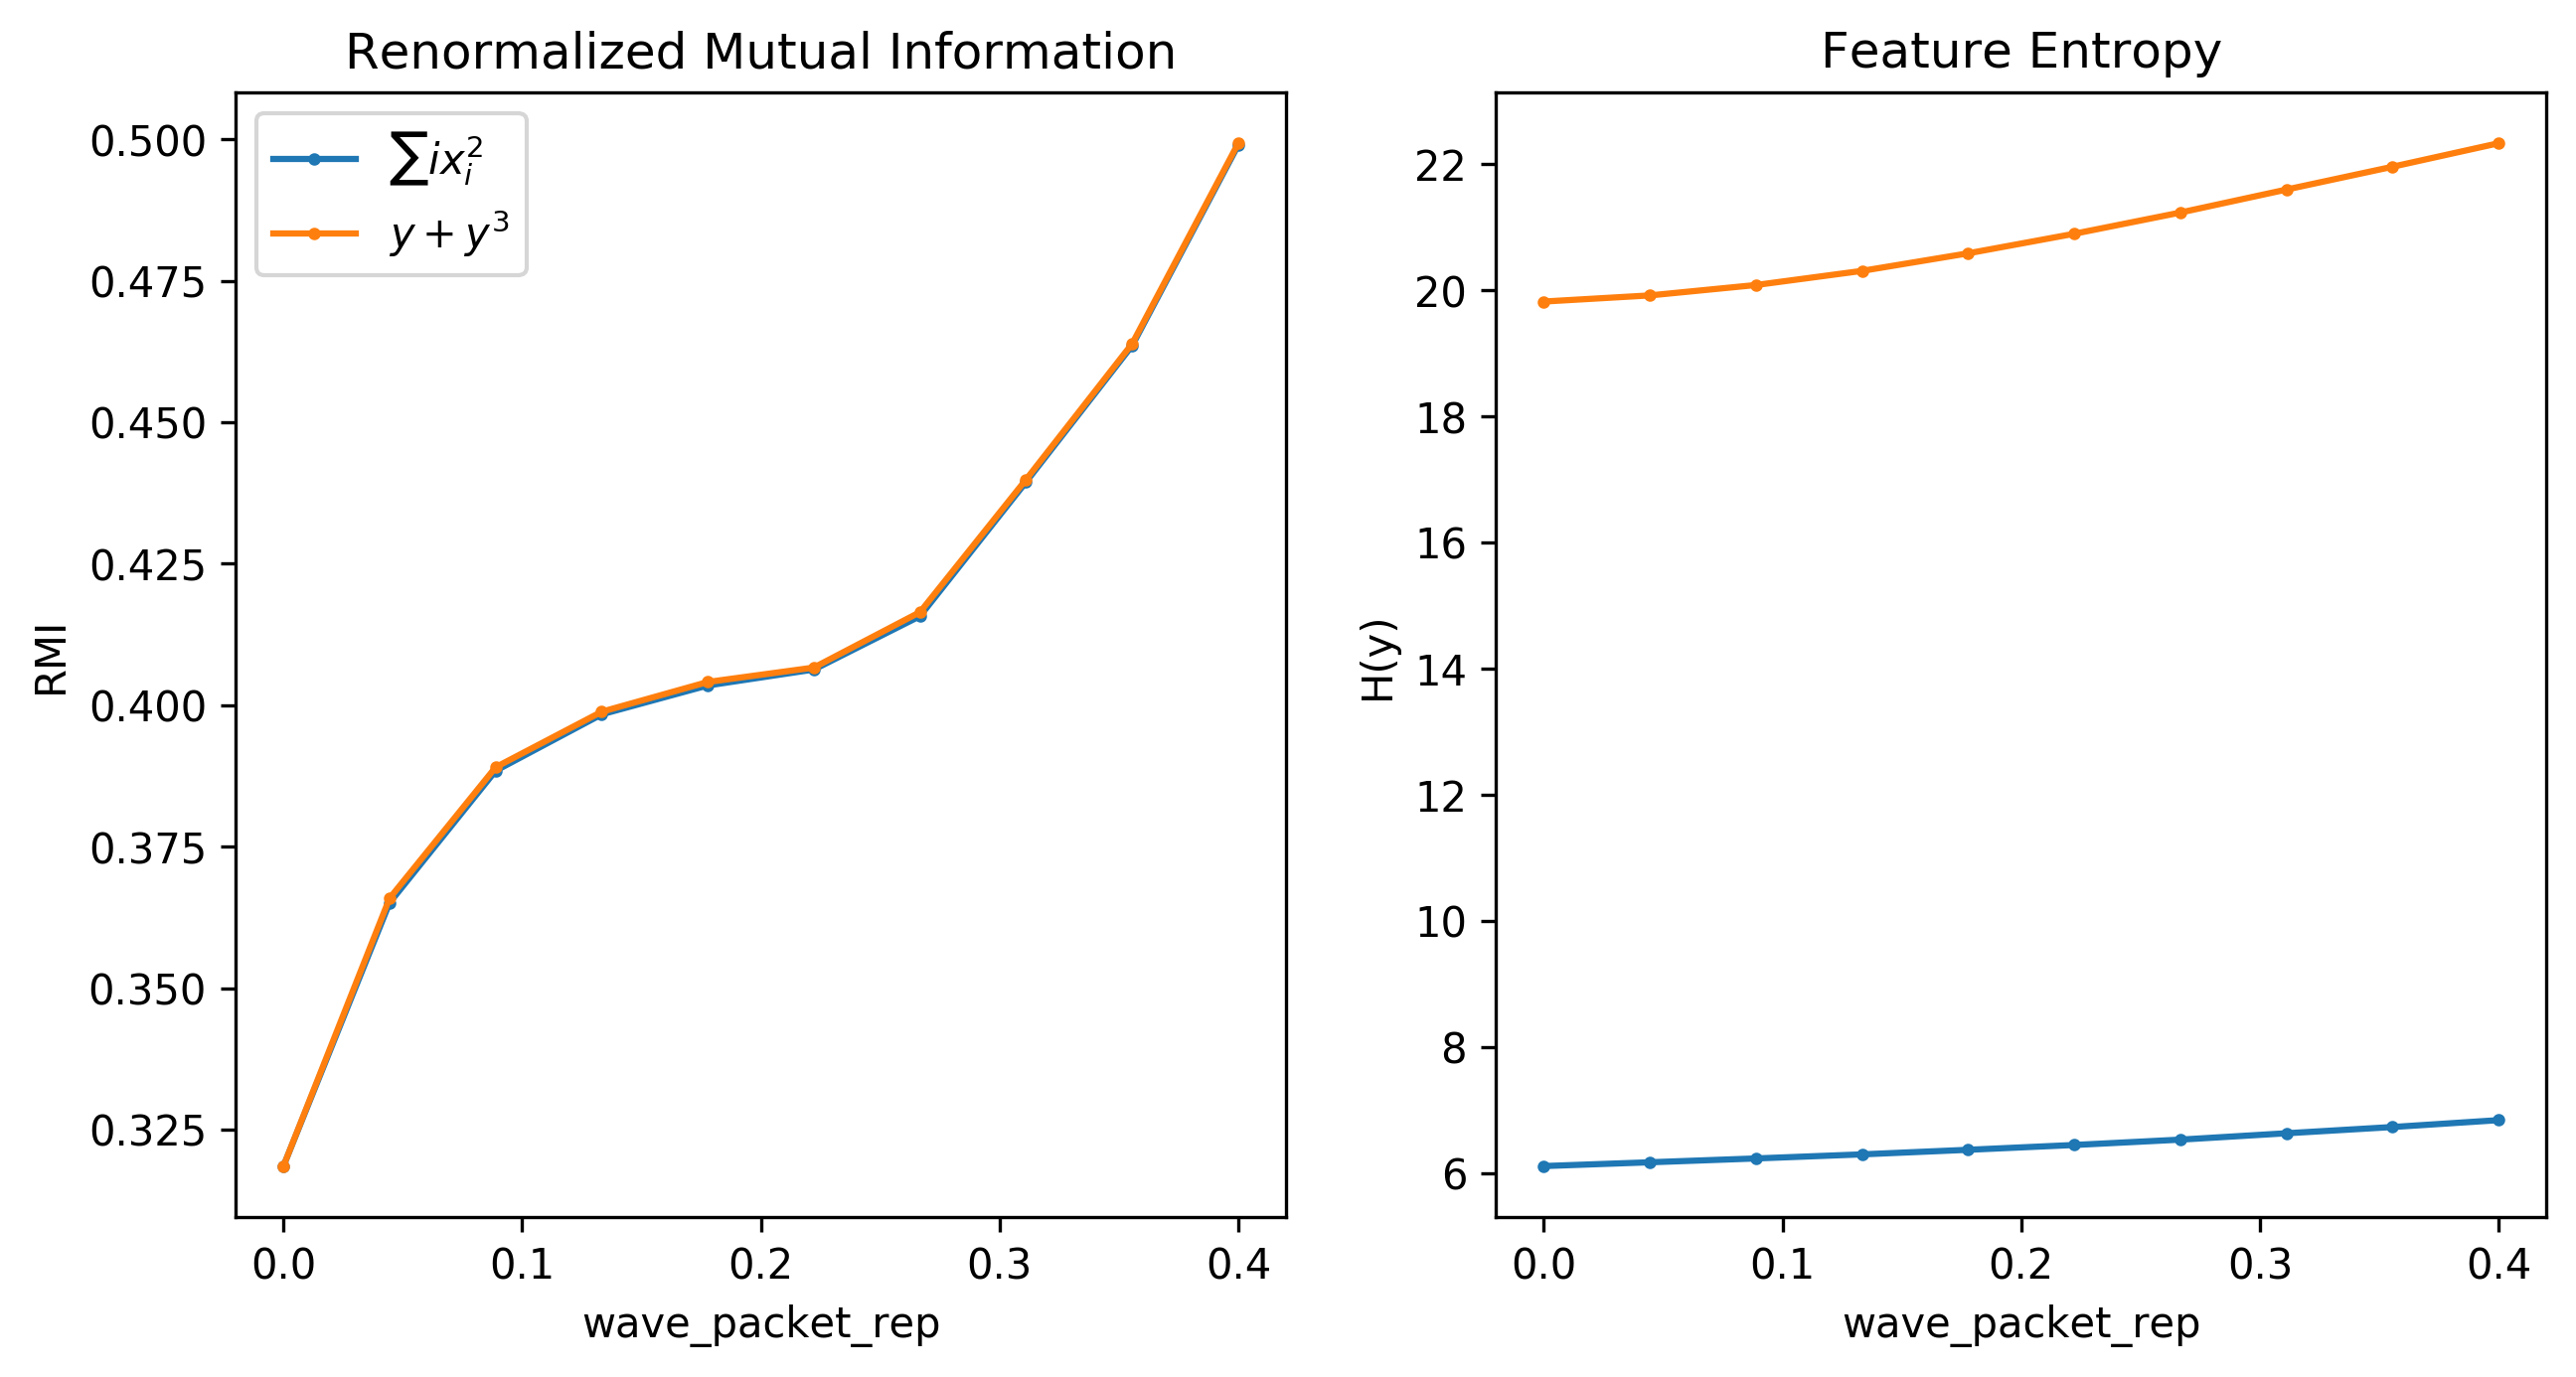

In [20]:
outputs_array = np.array(outputs)
plot_outputs_array(noises,outputs_array,fig="wave_packet_rep")

# Particles in a 1d potential

Simulate a system of particles in a potential and study some features in two different initial conditions:
- Squeezed: centered in zero, large initial spread
- Coherent: centered away from zero, small initial spread

The good feature to describe the two configuration are different: in the first case the spread of the particles gives more information, in the second case the center of mass

In [21]:
from utils.examples import Simulator

Osc_Spring=1.0 # harmonic well spring constant
Temperature_T=0.0
Squeezed = Simulator(n_particles=200,n_batch=20,
               force_params=[-Osc_Spring,0.0,0.0],
               spring_K=0.0,gamma=0.0,
               temperature=Temperature_T,
               x0=0.0,dx0=1.0,
               timestep=0.002,max_time=10.0)

Coherent = Simulator(n_particles=200,n_batch=20,
               force_params=[-Osc_Spring,0.0,0.0],
               spring_K=0.0,gamma=0.0,
               temperature=Temperature_T,
               x0=2.0,dx0=0.2,
               timestep=0.002,max_time=10.0)



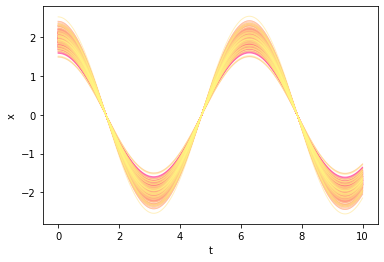

Feature              MI       H     MI-H
CM                   +3.85  +1.20  +2.65
Spread               +1.01  -1.64  +2.65
Spread_Centered      +3.17  +0.52  +2.65
Spread_Squared       +1.03  -3.19  +4.21
Sum of Squares       +3.18  +1.27  +1.91
PCA                  +3.85  +3.85  +0.00
var                  +1.03  -3.19  +4.21
cm;x2                +5.39  -1.48  +6.86


In [22]:
Xs, ts = Coherent.simulate()
Samples = Coherent.extract_batches(Xs)
Coherent.plot(ts, Xs)

inf.print_feature_batch(Samples,
                        [f.cm, f.sqrt_var, f.sqrt_x2, f.var, f.x2, f.pca,f.var,
                        lambda Samples: f.joinTwo(Samples, f.cm,f.x2)], 
                        ["CM" ,"Spread", "Spread_Centered",  "Spread_Squared", "Sum of Squares", "PCA","var",
                        "cm;x2"]);

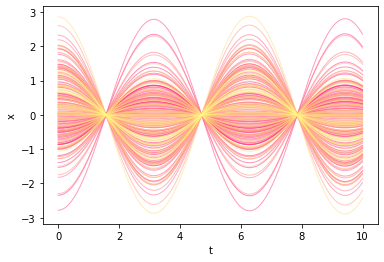

Feature              MI       H     MI-H
CM                   +1.17  -1.48  +2.65
Spread               +2.62  -0.02  +2.65
Spread_Centered      +2.62  -0.03  +2.65
Spread_Squared       +2.64  +0.01  +2.63
Sum of Squares       +2.64  +0.01  +2.63
PCA                  +2.39  +2.39  +0.00


In [23]:
Xs, ts = Squeezed.simulate()
Samples = Squeezed.extract_batches(Xs)
Squeezed.plot(ts, Xs)

inf.print_feature_batch(Samples,
                        [f.cm, f.sqrt_var, f.sqrt_x2, f.var, f.x2, f.pca], 
                        ["CM" ,"Spread", "Spread_Centered",  "Spread_Squared", "Sum of Squares", "PCA"]);

# Liquid Drops

In [ ]:
import utils.lennardjones as lj

Please note that parallel generation of the samples as here implemented may require _some_ memory.
Also, it is possible to reduce the number of thermalization steps `N_steps` to reduce the generation time.

In [ ]:
N_samples = 10000
N_particles = 250
deltaRstd = 0.15
d_attr = 0.4
drop_wall = 50
N_steps = 1000


In [ ]:
theta = np.random.uniform(0, 2*np.pi, size=(N_samples, 1, 1))
deltaR = np.random.randn(N_samples, 1, 1)*deltaRstd

In [ ]:
water = lj.Drop(R=1.0,
                deltaR=deltaR,
                theta=theta,
                ampl_confinement=drop_wall)

In [ ]:
interactions = lj.Interactions(d_collision=0.06,
                               d_attraction=d_attr)

In [ ]:
particles = lj.sample(N_samples, N_particles, water)

In [ ]:
lj.relax(particles, water, interactions, N_steps = N_steps)

In [ ]:
lj.plot_drop(0,particles,water,interactions,show3d=True)

In [ ]:
def separate_particles(samples, index):
    px = samples[:,:index]
    py = samples[:,index:]
    return px, py

def variance(samples):
    N_samples = np.shape(samples)[0]
    N_particles = int(np.shape(samples)[1]/2)
    px, py = separate_particles(samples, N_particles)

    varx = np.mean(px**2, -1)
    vary = np.mean(py**2, -1)

    grads = np.zeros([N_samples, 2, 2*N_particles])
    
    grad_varx = 2*px/N_particles
    grad_vary = 2*py/N_particles

    var = np.array([varx,vary]).T
    grads[:,0,:N_particles] = grad_varx
    grads[:,1,N_particles:] = grad_vary
    #grad_var = np.array([grad_varx,grad_vary]).swapaxes(0, 1)
    
    return var, grads

In [ ]:
samples = lj.particles_to_samples(particles)

In [ ]:
inf.MutualInformation(*variance(samples))